In [107]:
# Import basic modules

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns
from matplotlib import rcParams

# Import regression and error metrics modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from typing import List
from prophet import Prophet
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sktime.performance_metrics.forecasting import MedianAbsolutePercentageError

import pandas as pd

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [108]:
# Configure Pandas to display all columns and rows
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)

# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [155]:
df = pd.read_csv('data/power_data_with_features.csv')
df['dates'] = pd.to_datetime(df['dates'])

## The evaluation metrics that we would use to understand the model performance would be - 

- **`Root Mean Squared Error (RMSE)` - The difference between forecast and corresponding observed values are each squared and then averaged over the sample. Since, the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. These error metrics are expressed in the units.** <br>

- **`Mean Absolute Percentage Error (MAPE)` - This is one of the most popular used error metrics in time series forecasting. It is calculated by taking the average (mean) of the absolute difference between actuals and predicted values divided by the actuals.** <br>

- **`Median Absolute Percentage Error (MdAPE)` - This is similar to MAPE. It is the median of all absolute percentage errors calculated between the predictions and their corresponding actual values.**

## Util functions for modelling experiments

In [156]:
def get_train_test_data(df):
    
    df.rename(columns={'power_mwh':'y',
                       'dates': 'ds'}, inplace=True)
    
    train = df.loc[df.ds < '2017-09-14']
    test = df.loc[df.ds >= '2017-09-14']
    
    return train, test


def plot_forecast(train_forecast, test_forecast):
    plt.figure(figsize=(20,8))
    sns.lineplot(data=train_forecast, x='ds', y='y', label='actual')
    sns.lineplot(data=train_forecast, x='ds', y='yhat', label='forecasted')
    plt.title('Actual vs Forecasted for training data', fontsize=15)
    plt.xticks(fontsize=13)
    plt.xlabel('Timestamp', fontsize=15)
    plt.show()

    plt.figure(figsize=(20,8))
    sns.lineplot(data=test_forecast, x='ds', y='y', label='actual')
    sns.lineplot(data=test_forecast, x='ds', y='yhat', label='forecasted')
    plt.title('Actual vs Forecasted for testing data', fontsize=15)
    plt.xticks(fontsize=13)
    plt.xlabel('Timestamp', fontsize=15)
    plt.show()


def transform_data_and_generate_forecast(df: pd.DataFrame, model):
    col = [col for col in df.columns if col != 'y']
    df_2 = df[col] 
    forecast = model.predict(df_2)
    forecast = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
    df_forecast = pd.concat((forecast[['yhat', 'yhat_lower', 'yhat_upper']], df.reset_index()),axis=1).reset_index()
    
    return df_forecast



def add_model_regressors(model, regressors: List[str]):    
    
    for reg in regressors:
        model.add_regressor(f'{reg}', standardize=False)
    
    return model
    
    

eval_dict = {

               'Model': [], 'RMSE Train':[], 'RMSE Test':[], 'MAPE Train':[], 
               'MAPE Test':[], 'MDAPE Train':[], 'MDAPE Test':[]

            }
    
def evaluate_model_perf(
    eval_dict, 
    train_y: pd.DataFrame,
    train_yhat: pd.DataFrame,
    test_y: pd.DataFrame, 
    test_yhat: pd.DataFrame,
    model_type:str):
    
    eval_dict['Model'].append(model_type)
    
    eval_dict['RMSE Train'].append(mean_squared_error(train_y, train_yhat, squared=False))
    eval_dict['RMSE Test'].append(mean_squared_error(test_y, test_yhat, squared=False))
    
    eval_dict['MAPE Train'].append(mean_absolute_percentage_error(train_y, train_yhat))
    eval_dict['MAPE Test'].append(mean_absolute_percentage_error(test_y, test_yhat))
    
    mdape = MedianAbsolutePercentageError(symmetric=False)
    eval_dict['MDAPE Train'].append(mdape(train_y, np.array(train_yhat), squared=False))
    eval_dict['MDAPE Test'].append(mdape(test_y, np.array(test_yhat), squared=False))


    return eval_dict


## Baseline Model - Persistence Algorithm (the “naive” forecast)

**The persistence algorithm uses the value at the previous time step (t-x) to predict the expected outcome at the next time step (t+x). In our case, since the goal is to predict one day in the future and also from visualizations in every 3 months the patter resembles over the years - hence, we use 3 months old values to predict the next time step**

In [112]:
train_baseline, test_baseline = get_train_test_data(df)

len(train_baseline), len(test_baseline)

(67502, 7753)

In [113]:
test_duration = 7753

## Persistence algorithm with 90*24

predictions_test = []
for i in range(test_duration):
    predictions_test.append(train_baseline.iloc[-2160,1])
    
    # add test data to train
    train_baseline = train_baseline.append(test_baseline.iloc[i])
    
evaluate_model_perf(
    eval_dict, 
    np.zeros(8), 
    np.zeros(8), 
    test_baseline["y"], 
    predictions_test, 
   'baseline_persistence_model'
)

pd.DataFrame(eval_dict)

/usr/local/lib/python3.9/site-packages/sktime/performance_metrics/forecasting/_classes.py:411: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.9/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


,Model,RMSE Train,RMSE Test,MAPE Train,MAPE Test,MDAPE Train,MDAPE Test
0,baseline_persistence_model,0.00,"7,825.38",0.00,0.20,0.00,0.17


**For the sake of ease, we have only gone back far enough to generate predictions for the test data period and hence the train evaluation metrics are 0. The baseline model seems to be not too bad.**

## Label encode categorical features

In [157]:
le = preprocessing.LabelEncoder()
df['season_cat'] = le.fit_transform(df['season'])
df['weekday_cat'] = le.fit_transform(df['weekday'])
df['non_working_cat'] = le.fit_transform(df['non_working'])


## Remove redundant columns

In [158]:
df.drop(columns=['holiday', 'season', 'weekday', 'non_working'], inplace=True)
df.shape

(75255, 13)

In [159]:
df.head()

,dates,power_mwh,year,month,day,hour,power_mwh_lag_1,power_mwh_lag_2,power_mwh_lag_3,power_mwh_rolling_mean,season_cat,weekday_cat,non_working_cat
0,2010-01-01 00:00:00,"31,647.00",2010,1,1,0,"31,647.00","31,647.00","31,647.00","29,188.71",1,4,0
1,2010-12-31 01:00:00,"29,634.00",2010,12,31,1,"31,647.00","31,647.00","31,647.00","29,188.71",1,4,1
2,2010-12-31 02:00:00,"28,614.00",2010,12,31,2,"29,634.00","31,647.00","31,647.00","29,188.71",1,4,1
3,2010-12-31 03:00:00,"28,146.00",2010,12,31,3,"28,614.00","29,634.00","31,647.00","29,188.71",1,4,1
4,2010-12-31 04:00:00,"28,051.00",2010,12,31,4,"28,146.00","28,614.00","29,634.00","29,188.71",1,4,1


## Transform and split data

In [117]:
train, test = get_train_test_data(df)

<AxesSubplot:xlabel='ds', ylabel='y'>

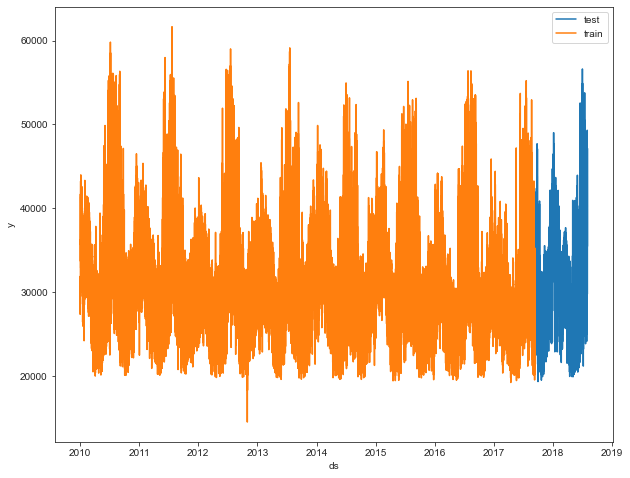

In [118]:
sns.lineplot(data=test, x='ds', y='y', label='test')
sns.lineplot(data=train, x='ds', y='y', label='train')

## Version 1 - Fit a basic 95% CI Prophet time series model

**We choose a facebook Prophet model as our basic parametric model. We will first train the Prophet model with only the original data as a univariate time series problem**

In [99]:
model_95_perc = Prophet(growth='linear', 
                        interval_width = 0.95, 
                        yearly_seasonality='auto',
                        weekly_seasonality='auto',
                        daily_seasonality='auto',
                        seasonality_mode='additive'
                 )


model_95_perc.fit(train)

16:44:31 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing


### Get predictions 

In [100]:
train_df_forecast = transform_data_and_generate_forecast(train, model_95_perc)
test_df_forecast = transform_data_and_generate_forecast(test, model_95_perc)

train_df_forecast.head()

,level_0,yhat,yhat_lower,yhat_upper,index,ds,y,year,month,day,hour,power_mwh_lag_1,power_mwh_lag_2,power_mwh_lag_3,power_mwh_rolling_mean,season_cat,weekday_cat,non_working_cat
0,0,"32,550.54","25,624.43","39,733.43",0,2010-01-01 00:00:00,"31,647.00",2010,1,1,0,"31,647.00","31,647.00","31,647.00","29,188.71",1,0,0
1,1,"30,629.02","23,909.23","37,277.37",1,2010-12-31 01:00:00,"29,634.00",2010,12,31,1,"31,647.00","31,647.00","31,647.00","29,188.71",1,0,1
2,2,"29,186.17","22,072.39","36,575.62",2,2010-12-31 02:00:00,"28,614.00",2010,12,31,2,"29,634.00","31,647.00","31,647.00","29,188.71",1,0,1
3,3,"28,342.13","21,361.38","35,978.12",3,2010-12-31 03:00:00,"28,146.00",2010,12,31,3,"28,614.00","29,634.00","31,647.00","29,188.71",1,0,1
4,4,"28,214.64","21,741.55","34,947.57",4,2010-12-31 04:00:00,"28,051.00",2010,12,31,4,"28,146.00","28,614.00","29,634.00","29,188.71",1,0,1


### Plot actual vs forecasted

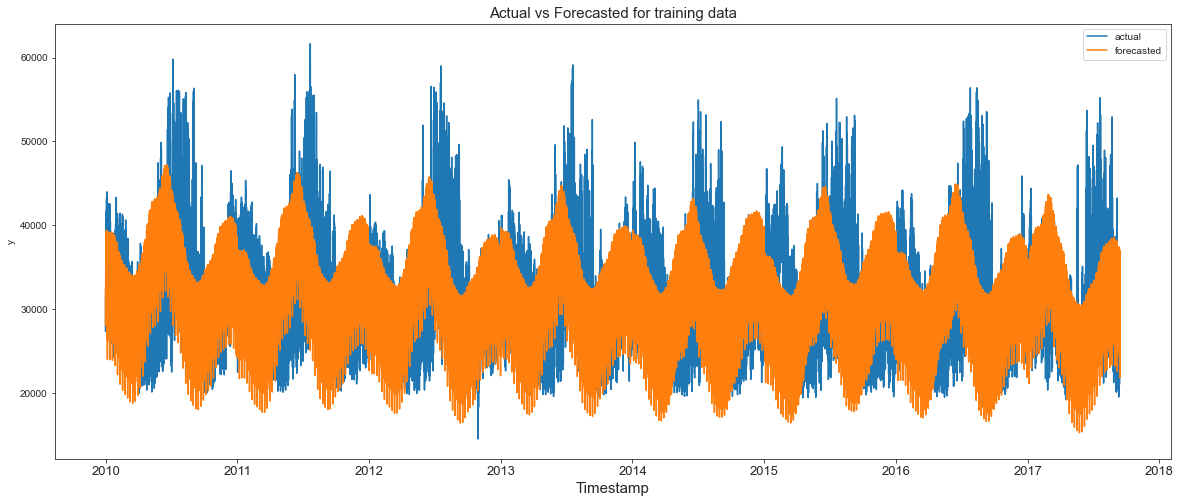

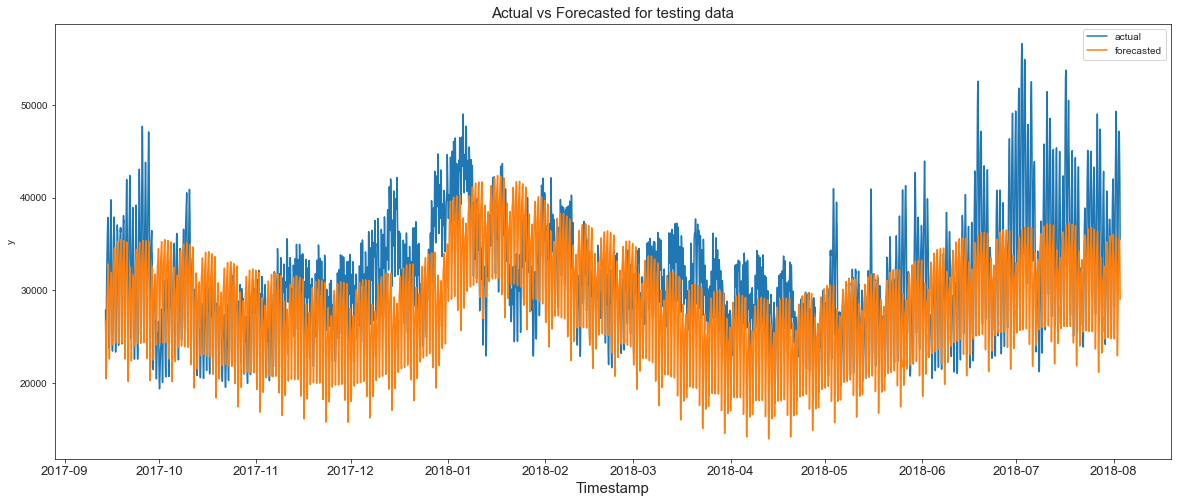

In [119]:
plot_forecast(train_df_forecast, test_df_forecast)

### Evaluate model performance

In [120]:
eval_dict = evaluate_model_perf(eval_dict,
                                train_df_forecast.y, 
                                train_df_forecast.yhat,
                                test_df_forecast.y, 
                                test_df_forecast.yhat,
                                'prophet_95_perc')

pd.DataFrame(eval_dict)

/usr/local/lib/python3.9/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.9/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


,Model,RMSE Train,RMSE Test,MAPE Train,MAPE Test,MDAPE Train,MDAPE Test
0,baseline_persistence_model,0.00,"7,825.38",0.00,0.20,0.00,0.17
1,prophet_95_perc,"6,549.12","5,431.51",0.17,0.13,0.14,0.12


**Looks like Prophet model is learning from the data better than the naive baseline model. Let's experiment with adding additional features that we generated.**

## Version 2 - Fit a 95% CI Prophet time series model with additional features

**We will now train the Prophet model with all the generated features data as a multivariate time series problem.**

In [126]:
model_95_perc_1 = Prophet(growth='linear', 
                          interval_width = 0.95, 
                          yearly_seasonality='auto',
                          weekly_seasonality='auto',
                          daily_seasonality='auto',
                          seasonality_mode='additive'
                 )

model_95_perc_1 = add_model_regressors(
          model_95_perc_1, 
          regressors=[col for col in train.columns if col not in ['ds', 'y']]
)


model_95_perc_1.fit(train)

17:01:10 - cmdstanpy - INFO - Chain [1] start processing
17:01:12 - cmdstanpy - INFO - Chain [1] done processing
17:01:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
17:01:16 - cmdstanpy - INFO - Chain [1] start processing
17:06:08 - cmdstanpy - INFO - Chain [1] done processing


### Get predictions 

In [127]:
train_df_forecast_all = transform_data_and_generate_forecast(train, model_95_perc_1)
test_df_forecast_all = transform_data_and_generate_forecast(test, model_95_perc_1)

train_df_forecast_all.head()

,level_0,yhat,yhat_lower,yhat_upper,index,ds,y,year,month,day,hour,power_mwh_lag_1,power_mwh_lag_2,power_mwh_lag_3,power_mwh_rolling_mean,season_cat,weekday_cat,non_working_cat
0,0,"30,605.79","28,816.61","32,313.99",0,2010-01-01 00:00:00,"31,647.00",2010,1,1,0,"31,647.00","31,647.00","31,647.00","29,188.71",1,0,0
1,1,"34,809.73","33,069.87","36,549.88",1,2010-12-31 01:00:00,"29,634.00",2010,12,31,1,"31,647.00","31,647.00","31,647.00","29,188.71",1,0,1
2,2,"26,565.15","24,734.31","28,245.45",2,2010-12-31 02:00:00,"28,614.00",2010,12,31,2,"29,634.00","31,647.00","31,647.00","29,188.71",1,0,1
3,3,"27,826.33","25,996.05","29,483.38",3,2010-12-31 03:00:00,"28,146.00",2010,12,31,3,"28,614.00","29,634.00","31,647.00","29,188.71",1,0,1
4,4,"28,177.13","26,428.93","29,982.84",4,2010-12-31 04:00:00,"28,051.00",2010,12,31,4,"28,146.00","28,614.00","29,634.00","29,188.71",1,0,1


### Plot actual vs forecasted

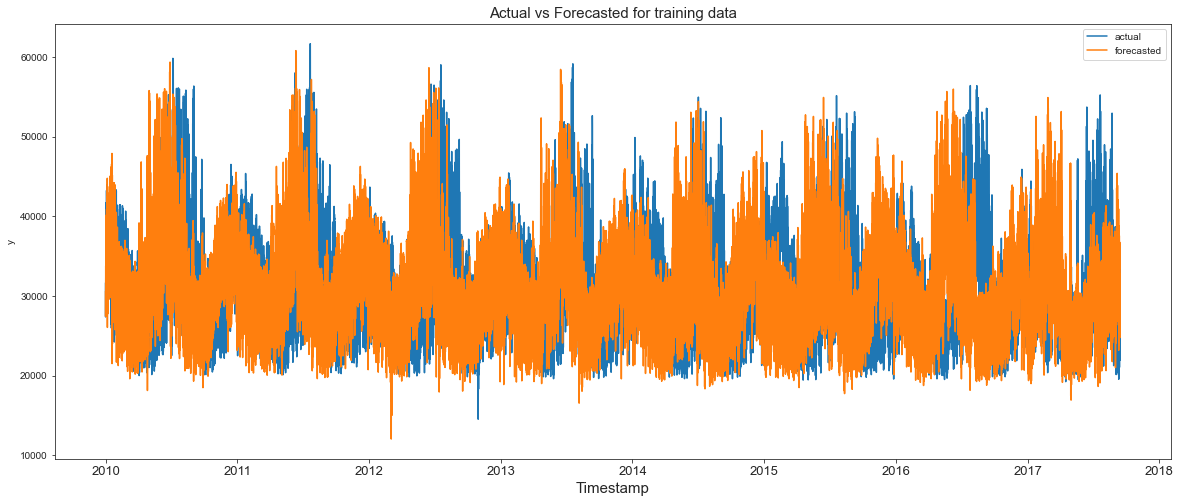

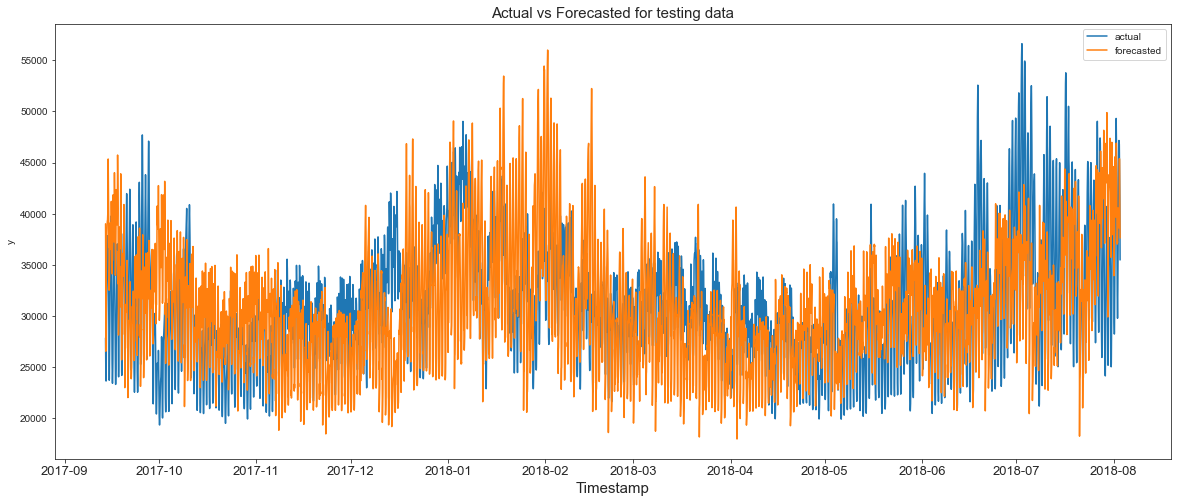

In [128]:
plot_forecast(train_df_forecast_all, test_df_forecast_all)

### Evaluate model performance

In [129]:
eval_dict = evaluate_model_perf(eval_dict,
                                train_df_forecast_all.y, 
                                train_df_forecast_all.yhat,
                                test_df_forecast_all.y, 
                                test_df_forecast_all.yhat,
                                'prophet_95_perc_all_add_regressors')

pd.DataFrame(eval_dict)


/usr/local/lib/python3.9/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.9/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


,Model,RMSE Train,RMSE Test,MAPE Train,MAPE Test,MDAPE Train,MDAPE Test
0,baseline_persistence_model,0.00,"7,825.38",0.00,0.20,0.00,0.17
1,prophet_95_perc,"6,549.12","5,431.51",0.17,0.13,0.14,0.12
2,prophet_95_perc_all_add_regressors,"7,268.72","6,092.89",0.18,0.15,0.15,0.13


**Oh no, turns out the variety of different features ended up creating more noise than helping the model capture signal. We will experiment with training the model with time based features and exclude the lagged and rolling window ones.**

## Version 3 - Fit a 95% CI Prophet time series model with additional features excluding lags and rolling mean

**We will now experiment with training the model with time based features and exclude the lagged and rolling window ones.**

In [130]:
model_95_perc_2 = Prophet(growth='linear', 
                          interval_width = 0.95, 
                          yearly_seasonality='auto',
                          weekly_seasonality='auto',
                          daily_seasonality='auto',
                          seasonality_mode='additive'
                 )

model_95_perc_2 = add_model_regressors(
          model_95_perc_2, 
          regressors=[col for col in train.columns if col not in ['ds', 'y', 'power_mwh_lag_1',
                                                                  'power_mwh_lag_2', 'power_mwh_lag_3', 
                                                                  'power_mwh_rolling_mean']]
)


model_95_perc_2.fit(train)

17:09:29 - cmdstanpy - INFO - Chain [1] start processing
17:10:08 - cmdstanpy - INFO - Chain [1] done processing


### Get predictions 

In [131]:
train_df_forecast_reg_no_lag = transform_data_and_generate_forecast(train, model_95_perc_2)
test_df_forecast_reg_no_lag = transform_data_and_generate_forecast(test, model_95_perc_2)

train_df_forecast_reg_no_lag.head()

,level_0,yhat,yhat_lower,yhat_upper,index,ds,y,year,month,day,hour,power_mwh_lag_1,power_mwh_lag_2,power_mwh_lag_3,power_mwh_rolling_mean,season_cat,weekday_cat,non_working_cat
0,0,"31,141.46","24,226.69","38,634.69",0,2010-01-01 00:00:00,"31,647.00",2010,1,1,0,"31,647.00","31,647.00","31,647.00","29,188.71",1,0,0
1,1,"31,421.89","24,253.85","38,581.30",1,2010-12-31 01:00:00,"29,634.00",2010,12,31,1,"31,647.00","31,647.00","31,647.00","29,188.71",1,0,1
2,2,"30,470.23","23,450.60","37,610.55",2,2010-12-31 02:00:00,"28,614.00",2010,12,31,2,"29,634.00","31,647.00","31,647.00","29,188.71",1,0,1
3,3,"29,495.46","22,041.86","36,462.42",3,2010-12-31 03:00:00,"28,146.00",2010,12,31,3,"28,614.00","29,634.00","31,647.00","29,188.71",1,0,1
4,4,"29,051.81","22,044.41","36,159.88",4,2010-12-31 04:00:00,"28,051.00",2010,12,31,4,"28,146.00","28,614.00","29,634.00","29,188.71",1,0,1


### Plot actual vs forecasted

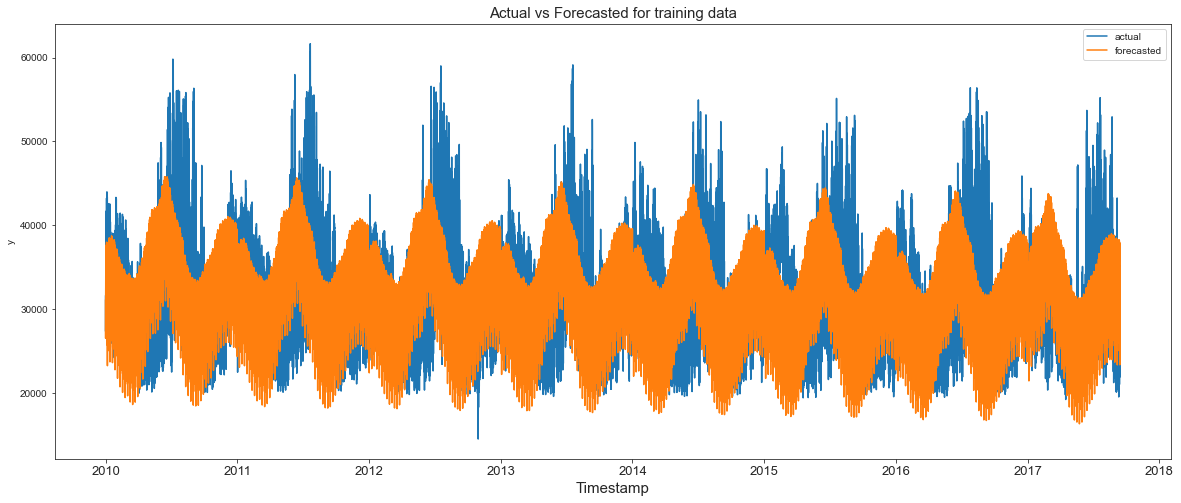

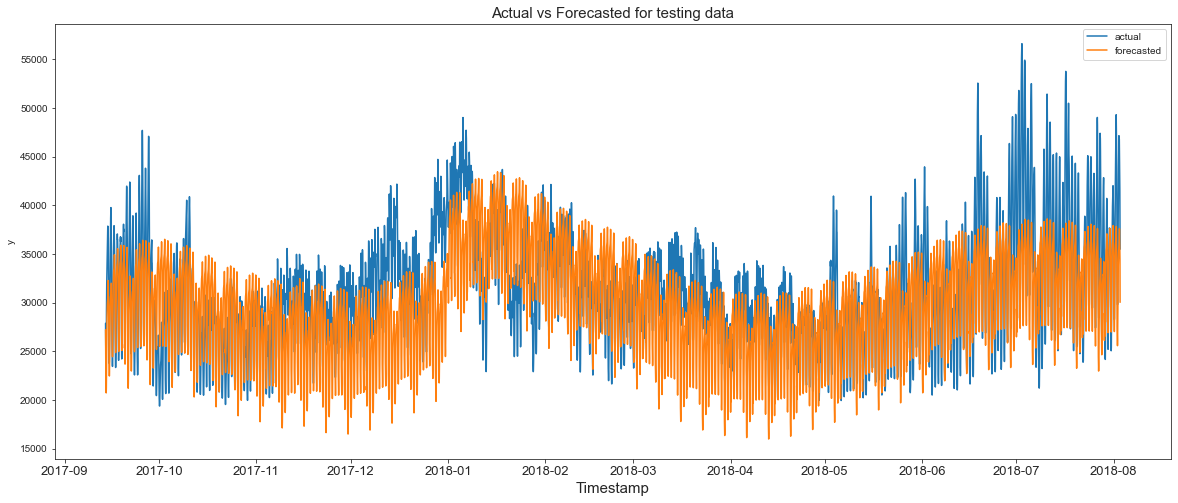

In [132]:
plot_forecast(train_df_forecast_reg_no_lag, test_df_forecast_reg_no_lag)

### Evaluate model performance

In [133]:
eval_dict = evaluate_model_perf(eval_dict,
                                train_df_forecast_reg_no_lag.y, 
                                train_df_forecast_reg_no_lag.yhat,
                                test_df_forecast_reg_no_lag.y, 
                                test_df_forecast_reg_no_lag.yhat,
                                'prophet_95_perc_all_regressors_no_lag')

pd.DataFrame(eval_dict)

/usr/local/lib/python3.9/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.9/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


,Model,RMSE Train,RMSE Test,MAPE Train,MAPE Test,MDAPE Train,MDAPE Test
0,baseline_persistence_model,0.00,"7,825.38",0.00,0.20,0.00,0.17
1,prophet_95_perc,"6,549.12","5,431.51",0.17,0.13,0.14,0.12
2,prophet_95_perc_all_add_regressors,"7,268.72","6,092.89",0.18,0.15,0.15,0.13
3,prophet_95_perc_all_regressors_no_lag,"6,493.29","5,018.83",0.16,0.12,0.14,0.11


**Looks like with additional features excluding lags and rolling window is slighlty better than a basic prophet model.**

## Train model with all data - train + test 

**For the sake of this case study, we will halt here and go ahead with training a full model with all of the provided data with some of the additional time based features.**

In [137]:
model = Prophet(growth='linear', 
                interval_width = 0.95, 
                yearly_seasonality='auto',
                weekly_seasonality='auto',
                daily_seasonality='auto',
                seasonality_mode='additive'
                 )

model = add_model_regressors(
          model, 
          regressors=[col for col in df.columns if col not in ['ds', 'y', 'power_mwh_lag_1',
                                                                'power_mwh_lag_2', 'power_mwh_lag_3', 
                                                                'power_mwh_rolling_mean']]
)


model.fit(df)

17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:26:27 - cmdstanpy - INFO - Chain [1] done processing


## Save model

In [138]:
import pickle

with open("model_prophet.pkl", "wb") as f:
    pickle.dump(model, f)
    

In [139]:
with open("le.pkl", "wb") as f:
    pickle.dump(le, f)